# Degree and distance

In [1]:
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)

The **degree** of a node is the number of edges that have the node as an endpoint.

In [3]:
degrees = pd.DataFrame(twitch.degree,columns=["node","degree"])
degrees

,node,degree
0,6194,6
1,255,6
2,980,18
3,2992,4
4,2507,22
...,...,...
7121,2933,1
7122,2267,1
7123,6694,1
7124,6995,1


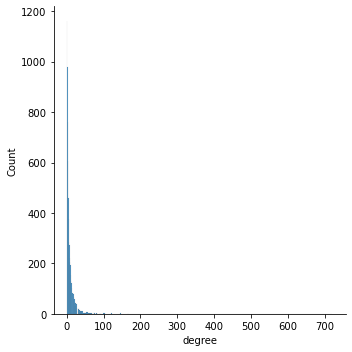

In [4]:
import seaborn as sns
hist = sns.displot(data=degrees,x="degree")

Let's compare the distribution to that of a random graph of the same size and edge density. This type of random graph selects every possible node with equal probability, which we will set to get roughly the same number of edges as in the Twitch network.

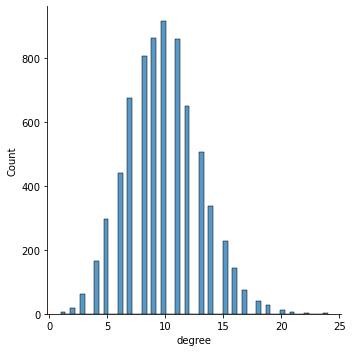

In [5]:
n = nx.number_of_nodes(twitch)
p = nx.number_of_edges(twitch)/(n*(n+1)/2)
rando = nx.erdos_renyi_graph(n,p)

dd = pd.DataFrame(rando.degree,columns=["node","degree"])
hist = sns.displot(data=dd,x="degree")

This is nothing like the Twitch network. This observation is general and well-known: *social networks are not like random networks.*

The behavior of the Twitch degree distribution gets very interesting when the axes are transformed to use log scales:

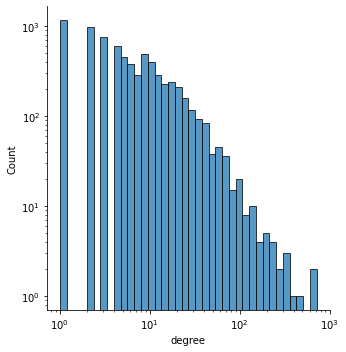

In [6]:
hist = sns.displot(data=degrees,x="degree",log_scale=True)
hist.axes[0,0].set_yscale("log")

For degrees between 10 and several hundred, the counts lie nearly on a straight line. That is, if $x$ is degree and $y$ is the node count at that degree, then

$$
\log(y) \approx  - a\cdot \log(x) + b,
$$

i.e.,

$$
y \approx B x^{-a},
$$

for some $a > 0$. This relationship is known as a **power law**. Many social networks follow a power-law distrubution of node degrees. 

A power law is an example of a *fat-talied* distribution; the decay of $x^{-a}$ as $x\to\infty$ is much slower than, say, the normal distribution's $e^{-x^2/2}$. One effect is that there is a significant disparity between the mean and median values of the node degrees:

In [7]:
degrees["degree"].describe()

count    7126.000000
mean        9.914117
std        22.190263
min         1.000000
25%         2.000000
50%         5.000000
75%        11.000000
max       720.000000
Name: degree, dtype: float64

Note also from the above that the standard deviation is much larger than the mean. This can be interpreted as another sign that the degree distribution is widely dispersed over orders of magnitude. As an idealization, the network can be described as *scale-free*.

We can get a fair estimate of the constants $B$ and $a$ in the power law by doing a least-squares fit on the logs of $x$ and $y$. First, we need the counts:

In [8]:
y = degrees["degree"].value_counts()
counts = pd.DataFrame({"degree":y.index,"count":y.values})
counts = counts[(counts["count"] > 10) & (counts["count"] < 200)];

Now we will get additional columns by log transformations. (Note: the `np.log` function is the natural logarithm.)

In [9]:
counts[["log_x","log_y"]] = counts.transform(np.log)

Now we use `sklearn` for a linear regression.

In [10]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(counts[["log_x"]],counts["log_y"])
lm.coef_,lm.intercept_

(array([-2.13584775]), 10.397579197774625)

The first value, which is both the slope of the line and the exponent of $x$ the power law, is the most interesting part. It estimates that the degree counts vary as $Bx^{-2.1}$ over a wide range of degrees.

A certain type of random graph known as a **Barabási–Albert** graph is constructed by connecting one node at a time. Edges are added randomly, but preference is given to connect to nodes that already have higher degree (i.e., are more "popular"). Because of this rule, there is a natural tendency to develop a few hubs of high degree.

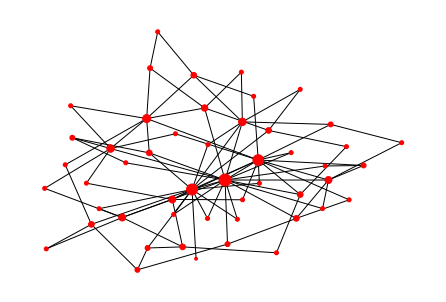

In [11]:
bag = nx.barabasi_albert_graph(50,2,seed=0)
bag_deg = pd.DataFrame(bag.degree,columns=["node","degree"])

nx.draw(bag,node_size=8*bag_deg["degree"],node_color="red")

When we scale the construction up to the size and average degree of the Twitch network, a power-law distribution emerges.

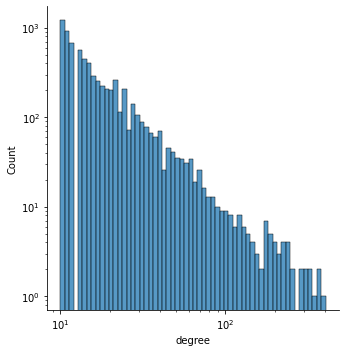

In [12]:
bag = nx.barabasi_albert_graph(n,round(p*n),seed=0)
bag_deg = pd.DataFrame(bag.degree,columns=["node","degree"])
hist = sns.displot(data=bag_deg,x="degree",log_scale=True)
hist.axes[0,0].set_yscale("log")

Compared to selecting from all possible edges with equal probabiliy, the Barabási–Albert model is considered a more plausible idealization of how social networks form.

## Distance

The **distance** between two nodes in a connected graph is the number of edges in the shortest path between them. This concept appears in the "Bacon number" game, where actors are nodes, appearing in the same movie creates an edge between them, and one tries to find the distance between Kevin Bacon and some other designated actor. 

The number of pairs of nodes in our Twitch network is moderately large.

In [13]:
print(n,"nodes create",(n-1)*n//2,"pairings")

7126 nodes create 25386375 pairings


It would take a while on a typical laptop to compute the distances between all such pairs. Instead, we will just randomly sample a healthy number of them.

In [14]:
from numpy.random import default_rng
rng = default_rng(1)
def pairdist(G,n):
    i = j = rng.integers(0,n)
    while i==j: j = rng.integers(0,n)
    return nx.shortest_path_length(G,source=i,target=j)

dist = [pairdist(twitch,n) for _ in range(100000)]
distances = pd.Series(dist)

In [15]:
distances.value_counts()

4    42813
3    36231
5    12570
2     6294
6     1724
7      191
1      159
8       17
9        1
dtype: int64

With over 7100 nodes, and an average of about 10 edges per node, the average distance between nodes is less than 4:

In [16]:
distances.mean()

3.67368

Node distances are related to the notion of "six degrees of separation" between any two people on Earth. This is a statement about the **diameter**, or maximum distance, of the human friendship network. In network analysis, this notion is called the *small-word phenomenon*. It's usually stated in terms of the mean degree, not the maximum, since the diameter can be determined by a single pair. (Even the little Twitch network above has a diameter of at least 9.) For a random network on $n$ nodes that have average degree $d$, the mean distance is approximately $\ln(n)/d$. For a scale-free network, it is even less.

In [17]:
from numpy.random import default_rng
rng = default_rng(1)

distances = pd.Series([pairdist(bag,n) for _ in range(100000)])

In [18]:
distances.mean()

2.99076

## Clustering

The small-world question is related to another type of network measurement: **clustering**. There are many ways to assess clustering, but we will use the **local clustering coefficient**. 

Suppose that node $i$ is adacent to $k$ other nodes, called its **neighborhood** (or level-1 ego graph). The nodes in the neighborhood have $k(k-1)/2$ possible edges between them. Suppose that there are $m$ edges between members of the neighborhood (exclusive of node $i$). The clustering coefficient of node $i$ is defined as

$$
c_i = \frac{2m}{k(k-1)}.
$$

If $c_i=0$, the neighborhood is starlike: none of the neighbors "talk to" (i.e., are adjacent to) each other. At the other extreme, if $c_i=1$, then the subgraph of the neighborhood is a complete graph. 

For example, here is the neighborhood of node 400.

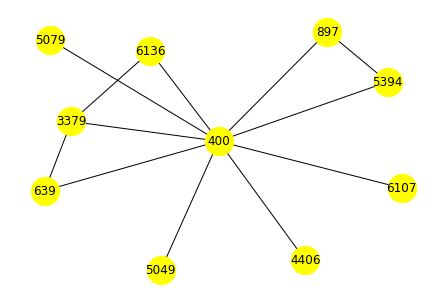

In [19]:
nbhood = nx.ego_graph(twitch,400)
nx.draw(nbhood,with_labels=True,node_size=800,node_color="yellow")

The plot reveals that the neighborhood has only 3 edges aside from those linking to node 400. Since there are 9 nodes in the neighborhood, this gives a clustering of 

$$
\frac{6}{9\cdot 8} = \frac{1}{12}.
$$

There is a function for computing this value, of course.

In [20]:
nx.clustering(twitch,400)

0.08333333333333333

The mean clustering coefficient is one way to assess the small-worldness of a graph.

In [21]:
pd.Series(nx.clustering(twitch)).mean()

0.13092821901472096

How do we put this number in context? The random BA graph has a much lower value.

In [22]:
pd.Series(nx.clustering(bag)).mean()

0.014265892136099337

This confirms that the BA construction does nothing to build community structure, only hubs. A Watts–Strogatz graph, on the other hand, starts from communities and just rewires some of the edges to create shortcuts. If we start from neighborhoods of size 10, the mean clustering is high:

In [23]:
ws = nx.watts_strogatz_graph(n,10,0,seed=2)
pd.Series(nx.clustering(ws)).mean()

0.6666666666666561

However, the mean path length in that graph would be large, since there are no far-flung direct connections. But if we allow 40% of the links to be converted to random destinations, then the clustering is similar to the Twitch graph:

In [24]:
ws = nx.watts_strogatz_graph(n,10,0.4,seed=11)
pd.Series(nx.clustering(ws)).mean()

0.1473302277666155

The mean distance is also comparable:

In [25]:
rng = default_rng(1)
pd.Series([pairdist(ws,n) for _ in range(50000)]).mean()

4.44962

As we computed above, the Twitch network has an even smaller mean distance, making it a bit more efficient at connecting nodes by paths.